In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
!unzip '/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/Datasets/DatasetBangla.zip'

In [41]:
ROOT_DIR = '/content/DatasetBangla'

train_set_root = os.path.join(ROOT_DIR, 'Train')
test_set_root = os.path.join(ROOT_DIR, 'Test')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor()
])

train_loader = DataLoader(
    ImageFolder(train_set_root, transform=transform),
    batch_size = 32, shuffle = True, pin_memory = True, drop_last = True, num_workers = 2
)

test_loader = DataLoader(
    ImageFolder(test_set_root, transform=transform),
    batch_size = 32, shuffle = True, pin_memory = True, drop_last = True, num_workers = 2
)

In [42]:
num_classes = len(os.listdir(train_set_root))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [49]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1*1*128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=2, stride=2, padding=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [34]:
# WORKS
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=128, out_channels=112, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=112, out_channels=96, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=96, out_channels=80, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=80, out_channels=64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=264, kernel_size=2, stride=1, padding=0)
#         )

#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=264, out_channels=64, kernel_size=2, stride=1, padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=64, out_channels=80, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=80, out_channels=96, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=96, out_channels=112, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=112, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [50]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [51]:
path = '/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/checkpoints/aec_ckp.pth'
outputs = []
current_loss = 1e10


# checkpoint = torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# current_loss = checkpoint['loss']
# EPOCHS = epoch + 10

model.train()
# for epoch in range(epoch, EPOCHS):
for epoch in range(10):
    for (imgs, _) in tqdm(train_loader):
        imgs = imgs.to(device)
        embd, recon = model(imgs.to(device))
        # print(embd.shape)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # break
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")

    outputs.append((epoch, imgs, recon))
    if current_loss > loss:
        loss = current_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }, path)
        print('model saved')
    # break

100%|██████████| 375/375 [00:06<00:00, 60.76it/s]


Epoch: 1, Loss: 0.0348
model saved


100%|██████████| 375/375 [00:06<00:00, 60.25it/s]


Epoch: 2, Loss: 0.0401
model saved


100%|██████████| 375/375 [00:06<00:00, 61.09it/s]


Epoch: 3, Loss: 0.0374
model saved


100%|██████████| 375/375 [00:07<00:00, 50.00it/s]


Epoch: 4, Loss: 0.0211
model saved


100%|██████████| 375/375 [00:06<00:00, 60.15it/s]


Epoch: 5, Loss: 0.0246
model saved


100%|██████████| 375/375 [00:06<00:00, 60.45it/s]


Epoch: 6, Loss: 0.0232
model saved


100%|██████████| 375/375 [00:06<00:00, 59.66it/s]


Epoch: 7, Loss: 0.0151
model saved


100%|██████████| 375/375 [00:06<00:00, 60.95it/s]


Epoch: 8, Loss: 0.0190
model saved


100%|██████████| 375/375 [00:06<00:00, 55.36it/s]


Epoch: 9, Loss: 0.0135
model saved


100%|██████████| 375/375 [00:07<00:00, 51.76it/s]

Epoch: 10, Loss: 0.0154
model saved


In [52]:
all = glob.glob(ROOT_DIR+'/*/*/*.bmp')
train = glob.glob('/content/DatasetBangla/Train/*/*.bmp')
test = glob.glob('/content/DatasetBangla/Test/*/*.bmp')

len(all), len(train), len(test)

(15000, 12000, 3000)

torch.Size([32, 128])
tensor([[[0.4971, 0.4983, 0.5004,  ..., 0.4229, 0.4320, 0.4605],
         [0.4903, 0.4920, 0.5010,  ..., 0.3976, 0.4204, 0.4600],
         [0.5013, 0.4994, 0.4993,  ..., 0.3850, 0.4021, 0.4460],
         ...,
         [0.4930, 0.4979, 0.4985,  ..., 0.4885, 0.4715, 0.4882],
         [0.4922, 0.4907, 0.4939,  ..., 0.4791, 0.4865, 0.4911],
         [0.4926, 0.4970, 0.4977,  ..., 0.4908, 0.4891, 0.4922]],

        [[0.4958, 0.5007, 0.5048,  ..., 0.4294, 0.4370, 0.4635],
         [0.4918, 0.4980, 0.4982,  ..., 0.3967, 0.4152, 0.4540],
         [0.5061, 0.5030, 0.5024,  ..., 0.3844, 0.4045, 0.4459],
         ...,
         [0.4957, 0.5024, 0.5006,  ..., 0.4981, 0.4809, 0.4946],
         [0.4906, 0.4967, 0.4948,  ..., 0.4774, 0.4902, 0.4977],
         [0.5000, 0.5078, 0.5022,  ..., 0.4925, 0.4906, 0.5004]],

        [[0.4969, 0.4978, 0.5016,  ..., 0.4229, 0.4397, 0.4618],
         [0.4949, 0.4966, 0.5003,  ..., 0.4006, 0.4220, 0.4622],
         [0.5024, 0.4991, 0.5037,  .

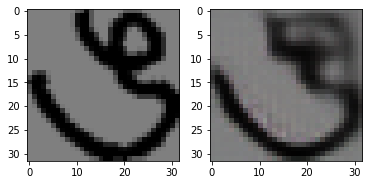

In [53]:
model.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        enc, dec = model(imgs)
        print(enc.flatten(start_dim=1).shape)
        print(dec[0])
        outimg = np.transpose(dec[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        break

In [55]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5), (0.5)),
])

embeddings = []
for idx in range(172, 172+50):
    img_path = f'/content/DatasetBangla/Test/{idx}/bcc000020.bmp'
    img = test_transform(cv2.imread(img_path))
    # print(img.shape)

    embd, recon = model(img.unsqueeze(0).to(device))
    embd = embd.view(-1, embd.shape[1])
    # print(embd.shape, recon.shape)
    embeddings.append(list(embd[0].cpu().detach().numpy()))



# embeddings = []
# for idx in range(172, 172+50):
#     embds = 0
#     imgs = glob.glob(f'/content/Dataset/Test/{idx}/*.bmp')
#     for img in imgs:
#         img = test_transform(cv2.imread(img_path))
#         # print(img.shape)
#         embd, recon = model(img.unsqueeze(0).to(device))
#         embd = embd.view(-1, 64)
#         embd = embd[0].cpu().detach().numpy()
#         # print(embd.shape)
#         embds += embd
#         # break
#     # print(embds/len(imgs))
#     embds = embds/len(imgs)
#     embeddings.append(embds)
#     # break
        

np.array(embeddings).shape

(50, 128)

In [56]:
import pandas as pd
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

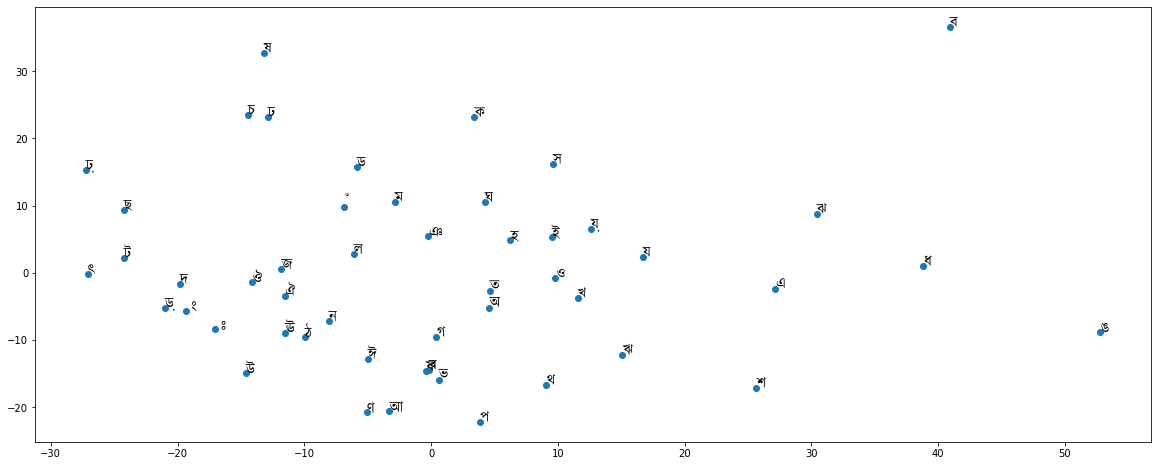

In [57]:
prop = fm.FontProperties(fname='/content/drive/MyDrive/PROJECTS/ZS-GZS HCR/required files/kalpurush.ttf')

X = embeddings
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 8))
plt.scatter(result[:, 0], result[:, 1])

chars = [
    'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 
    'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', 'ড়', 'ঢ়', 'য়', 'ৎ',' ং',' ঃ', ' ঁ',
    # 'অনুস্বার','বিসর্গ', 'চন্দ্রবিন্দু'
]

for i, char in enumerate(chars):
    plt.annotate(
        char,
        xy = (result[i, 0], result[i, 1]),
        fontproperties=prop,
        fontsize=15
    )

plt.show()